In [2]:
import tensorflow as tf
import mediapipe as mp
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
import time
print("joe")

joe


In [3]:
mp_hol = mp.solutions.holistic
mp_draw = mp.solutions.drawing_utils
mp_face = mp.solutions.face_mesh 

In [4]:
def mp_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
import os
os.getcwd()


'C:\\Users\\bshab\\Code\\Signlangdetec'

In [6]:
def draw_landmarks(image, results):
    mp_draw.draw_landmarks(image, results.face_landmarks, mp_face.FACEMESH_TESSELATION,
                           mp_draw.DrawingSpec(color=(85, 110, 10), thickness=1, circle_radius=1),
                           mp_draw.DrawingSpec(color=(85, 256, 121), thickness=1, circle_radius=1)
                          )
    mp_draw.draw_landmarks(image, results.pose_landmarks, mp_hol.POSE_CONNECTIONS, 
                           mp_draw.DrawingSpec(color=(85, 110, 10), thickness=1, circle_radius=4),
                           mp_draw.DrawingSpec(color=(85, 256, 121), thickness=1, circle_radius=2))
    mp_draw.draw_landmarks(image, results.left_hand_landmarks, mp_hol.HAND_CONNECTIONS, mp_draw.DrawingSpec(color=(85, 110, 10), thickness=1, circle_radius=1),
                           mp_draw.DrawingSpec(color=(85, 256, 121), thickness=1, circle_radius=4))
    mp_draw.draw_landmarks(image, results.right_hand_landmarks, mp_hol.HAND_CONNECTIONS, mp_draw.DrawingSpec(color=(85, 110, 10), thickness=1, circle_radius=1),
                           mp_draw.DrawingSpec(color=(85, 256, 121), thickness=1, circle_radius=2))

In [7]:
cap = cv2.VideoCapture(1)

with mp_hol.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mp_detection(frame, holistic)

        draw_landmarks(image, results)
        
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

**Extracting Keypoint Values to make an array from them**

In [8]:
def extract_keypoints(results):
    # Pose keypoints
    if results.pose_landmarks:
        pose = np.array([
            [res.x, res.y, res.z, res.visibility]
            for res in results.pose_landmarks.landmark
        ]).flatten()
    else:
        pose = np.zeros(33 * 4)

    if results.face_landmarks:
        face = np.array([
            [res.x, res.y, res.z]
            for res in results.face_landmarks.landmark
        ]).flatten()
    else:
        face = np.zeros(468 * 3)

    if results.left_hand_landmarks:
        lh = np.array([
            [res.x, res.y, res.z]
            for res in results.left_hand_landmarks.landmark
        ]).flatten()
    else:
        lh = np.zeros(21 * 3)

    if results.right_hand_landmarks:
        rh = np.array([
            [res.x, res.y, res.z]
            for res in results.right_hand_landmarks.landmark
        ]).flatten()
    else:
        rh = np.zeros(21 * 3)

    return np.concatenate([pose, face, lh, rh])


In [9]:
result_test = extract_keypoints(results)

In [16]:
np.save('0', result_test)

In [17]:
np.load('0.npy')

array([ 0.51016623,  0.59523743, -0.65227926, ...,  0.        ,
        0.        ,  0.        ])

**Creating folders to collect data**

In [18]:
DATA_PATH = os.path.join('MP_Data')

##detecting 3 diff actions
actions = np.array(['hello', 'thanks', 'i love you'])

##30 vids of data
no_seq = 30

#each vid is 30 frames long
seq_len = 30

In [19]:
for action in actions:
    for sequence in range (no_seq):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [20]:
cap = cv2.VideoCapture(1)

with mp_hol.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range (no_seq):
            for frame_num in range(seq_len):
                ret, frame = cap.read()
                image, results = mp_detection(frame, holistic)
                draw_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image,'START COLLECTION', (120,200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence),(15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1,cv2.LINE_AA)
                    cv2.imshow('OpenCV feed', image)

                    cv2.waitKey(1000)

                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence),(15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255),1,cv2.LINE_AA)
                    cv2.imshow('OpenCV feed', image)

                keypoints=extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

In [15]:
cap.release()
cv2.destroyAllWindows()

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [23]:
label_map = {label:num for num, label in enumerate(actions)}

In [24]:
label_map

{'hello': 0, 'thanks': 1, 'i love you': 2}

In [25]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_seq):
        window = []
        for frame_num in range(seq_len):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [27]:
np.array(sequences).shape

(90, 30, 1662)

In [28]:
np.array(labels).shape

(90,)

In [29]:
X = np.array(sequences)

In [30]:
X.shape

(90, 30, 1662)

In [31]:
y = to_categorical(labels).astype(int)

In [32]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [35]:
y_test.shape
X_train.shape

(85, 30, 1662)

# Build and Train an LSTM

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [39]:
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [43]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


In [42]:
res = [.7, 0.2, 0.1]

In [46]:
actions[np.argmax(res)]

'hello'

In [49]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [54]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[]
2.13.0


In [55]:
model.fit(X_train, y_train, epochs = 3000, callbacks=[tb_callback])

Epoch 1/3000
3/3 [==============================] - 0s 65ms/step - loss: 0.4674 - categorical_accuracy: 0.8235
Epoch 2/3000
3/3 [==============================] - 0s 66ms/step - loss: 0.4393 - categorical_accuracy: 0.8706
Epoch 3/3000
3/3 [==============================] - 0s 61ms/step - loss: 0.4079 - categorical_accuracy: 0.8706
Epoch 4/3000
3/3 [==============================] - 0s 52ms/step - loss: 0.4103 - categorical_accuracy: 0.8353
Epoch 5/3000
3/3 [==============================] - 0s 58ms/step - loss: 0.5896 - categorical_accuracy: 0.6588
Epoch 6/3000
3/3 [==============================] - 0s 59ms/step - loss: 0.4376 - categorical_accuracy: 0.8235
Epoch 7/3000
3/3 [==============================] - 0s 48ms/step - loss: 0.3658 - categorical_accuracy: 0.8706
Epoch 8/3000
3/3 [==============================] - 0s 56ms/step - loss: 0.3911 - categorical_accuracy: 0.8471
Epoch 9/3000
3/3 [==============================] - 0s 62ms/step - loss: 0.2826 - categorical_accuracy: 0.8824
E

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 59667

In [58]:
model.predict(X_test)

1/1 [==============================] - 0s 293ms/step


array([[1.5204376e-16, 9.4286029e-22, 1.0000000e+00],
       [8.7420945e-19, 2.2495872e-12, 1.0000000e+00],
       [1.0000000e+00, 2.1082538e-17, 1.4295669e-09],
       [2.5472144e-17, 2.1212749e-09, 1.0000000e+00],
       [3.9267689e-15, 1.0634026e-15, 1.0000000e+00]], dtype=float32)

In [59]:
res[0]


0.7

In [65]:
actions[np.argmax(res[2])]

'hello'

In [67]:
actions[np.argmax(y_test[1])]

'i love you'

In [96]:
model.save('action.keras')

In [70]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [71]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 24ms/step


In [72]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [73]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[1, 0],
        [0, 4]]], dtype=int64)

In [74]:
accuracy_score(ytrue, yhat)

1.0

In [89]:
colors = [(245,117,16),(117,245,16),(16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, 
                      (0,60+num*40), 
                      (int(prob*100), 90+num*40), 
                      colors[num], 
                      -1
                     )
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255),2,cv2.LINE_AA)
    return output_frame

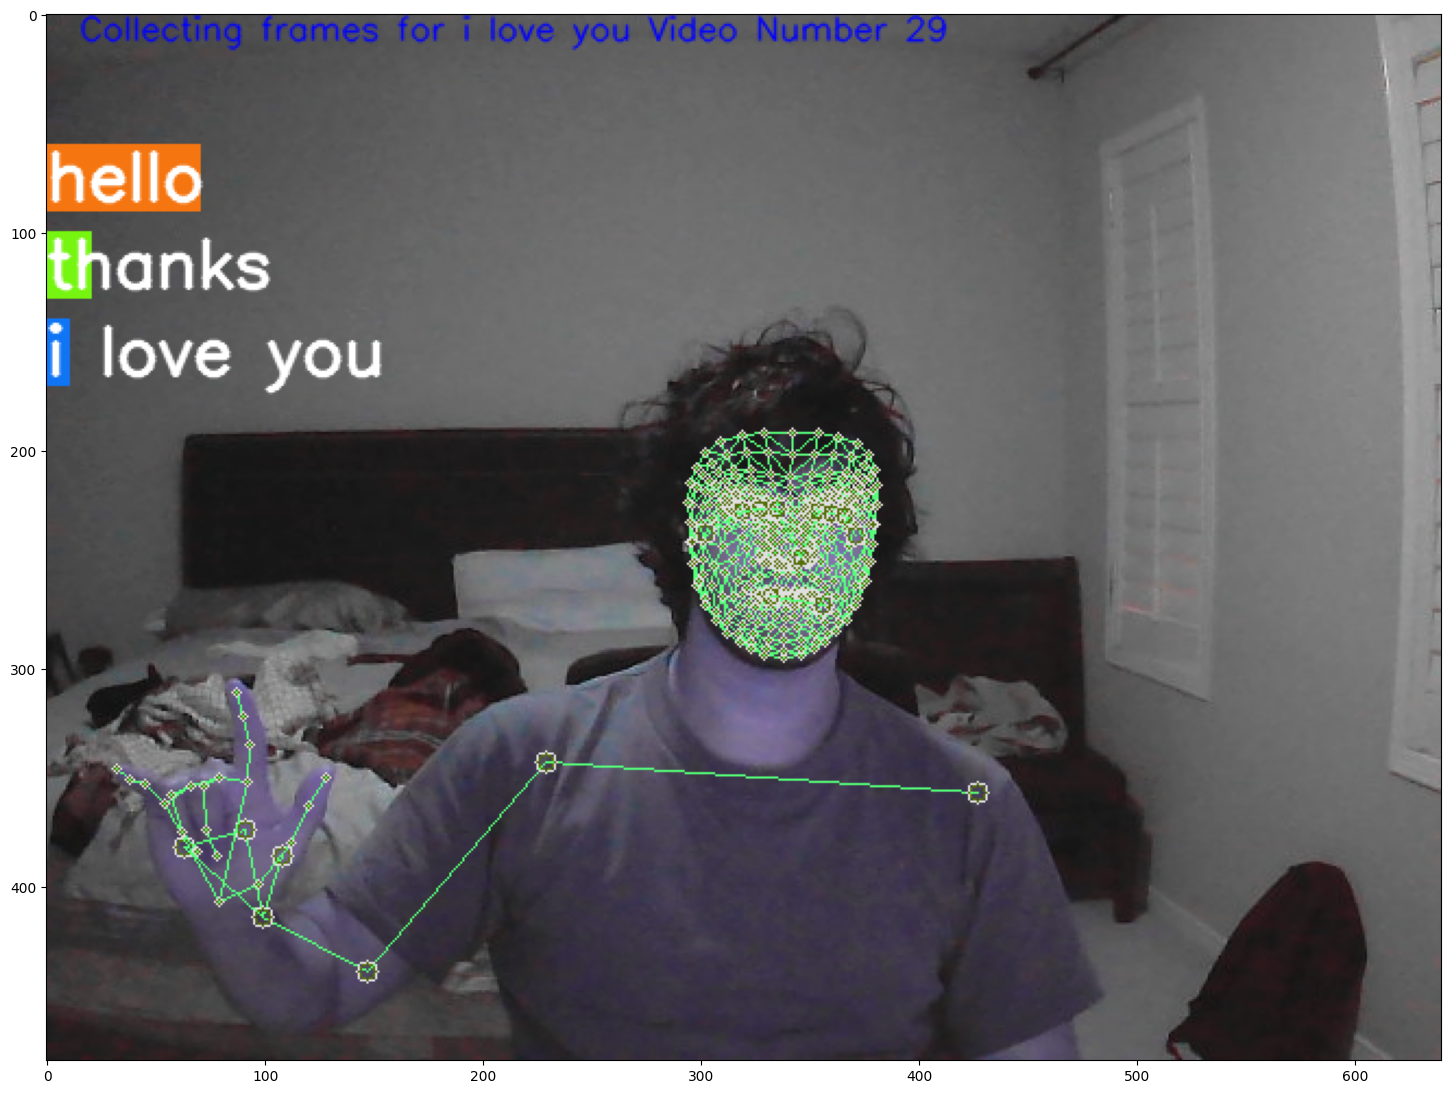

In [90]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res,actions,image,colors))

In [92]:
sequence=[]
sentence =[]
threshold=0.8

cap = cv2.VideoCapture(1)

with mp_hol.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mp_detection(frame, holistic)
        print(results)

        draw_landmarks(image, results)

        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) ==30:
            res = model.predict(np.expand_dims(sequence,axis=0))[0]
            print(actions[np.argmax(res)])


            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence)>5:
                    sentence = sentence[-5:]

            image = prob_viz(res,actions,image,colors)

        cv2.rectangle(image,(0,0),(640,40),(245,117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

            
            
            
        
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [93]:
cap.release()
cv2.destroyAllWindows()

In [94]:
res[np.argmax(res)] > threshold

True

In [95]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 [==============================] - 0s 22ms/step


array([[1.520426e-16, 9.428388e-22, 1.000000e+00]], dtype=float32)